In [ ]:
!nvidia-smi --list-gpus

GPU 0: Tesla T4 (UUID: GPU-a63013d7-1519-1e92-c5e0-934aa36f3fd1)


### Downloading the Data
Ensure that you have uploaded the dataset to the colab environment.

In [ ]:
!pip install gdown --quiet
import gdown
url = 'https://drive.google.com/uc?id=18pulZkIQzDHGkH-UrDzxHp_giSxerTag'
#url = 'https://drive.google.com/drive/folders/1z1sqWHyj7n-rWXGkW-nCMZjQXJLMPqCd?usp=share_link'
# url = 'https://drive.google.com/uc?id=1ImrsoqvQ3JC-iGW2znQmfkoZyL5E3icJ'
# url = 'https://drive.google.com/uc?id=1S-OJVgxKXDeS5gmqJwzUaCpXmuT4zWcu'
output = 'animals.zip'
gdown.download(url, output, quiet=True)

'animals.zip'

In [ ]:
!unzip animals.zip
print("Done.")

Archive:  animals.zip
   creating: cats-dogs-wolves-/
  inflating: __MACOSX/._cats-dogs-wolves-  
   creating: cats-dogs-wolves-/testData/
  inflating: cats-dogs-wolves-/.DS_Store  
  inflating: __MACOSX/cats-dogs-wolves-/._.DS_Store  
   creating: cats-dogs-wolves-/datasets/
   creating: cats-dogs-wolves-/testData/dogs/
   creating: cats-dogs-wolves-/testData/cats/
  inflating: cats-dogs-wolves-/testData/.DS_Store  
  inflating: __MACOSX/cats-dogs-wolves-/testData/._.DS_Store  
   creating: cats-dogs-wolves-/testData/wolves/
   creating: cats-dogs-wolves-/datasets/dogs/
   creating: cats-dogs-wolves-/datasets/cats/
  inflating: cats-dogs-wolves-/datasets/.DS_Store  
  inflating: __MACOSX/cats-dogs-wolves-/datasets/._.DS_Store  
   creating: cats-dogs-wolves-/datasets/wolves/
  inflating: cats-dogs-wolves-/testData/dogs/n02105251_4569.jpg  
  inflating: __MACOSX/cats-dogs-wolves-/testData/dogs/._n02105251_4569.jpg  
  inflating: cats-dogs-wolves-/testData/dogs/n02108000_2653.jpg  
  in

In [ ]:
!find . -name '.DS_Store' -type f -delete

train_path = 'cats-dogs-wolves-/datasets'
test_path = 'cats-dogs-wolves-/testData'
print("Paths Loaded.")

Paths Loaded.


### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project.

In [ ]:
%tensorflow_version 2.x
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
#from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
print("Import Success!")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Import Success!


In [ ]:
image_size = (224, 224)
classes = ['cats', 'dogs', 'wolves']

train_datagen = ImageDataGenerator(validation_split=0.25) # set validation split

train_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=15, subset='training')
valid_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=8, subset='validation')
test_batches = ImageDataGenerator().flow_from_directory(test_path, image_size, classes=classes, batch_size=133)

Found 272 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


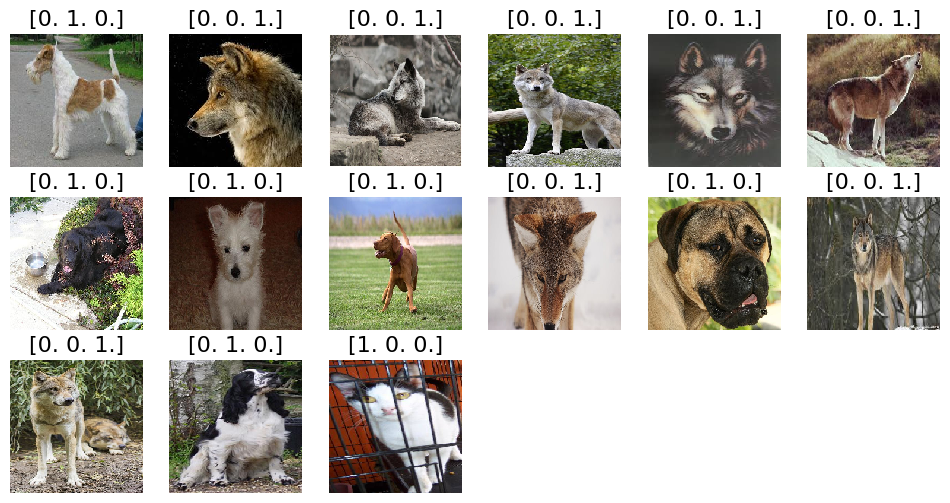

In [ ]:
# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(str(titles[i]), fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)

# we plot these samples of images and their labels 1 batch at a time.
plots(imgs, titles=labels, rows=3)

In [ ]:
vgg16_model = tensorflow.keras.applications.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


### Creating a Custom Output Model#

A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model.  This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribuiton adding up to unity. Therefore, our model will output a probability distribution among the classes as output for each input image.

In [ ]:
from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model = Sequential()

# Add all layers from VGG16 except the output layer
for layer in vgg16_model.layers:
    model.add(layer)

# Freeze the layers from VGG16
for layer in model.layers:
    layer.trainable = False

# Add custom layers on top of the base VGG16 model
model.add(Flatten(name='flatten_output'))  # Provide a unique name for the Flatten layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(
    len(classes),  # Number of output classes
    activation='softmax',
    kernel_regularizer=regularizers.l2(0.01)  # Add L2 regularization
))

# Print the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_output (Flatten)             │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │          75,267 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training the Model

Now that the model has been specified, it must be trained.




### Compiling the Model
First,the model is compiled. The performance of the model is evalued using a loss function, which increases as performance decreases. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a scalar value, the correct loss function would be 'mean_squared_error'.

In [ ]:
#model.compile(Adam(lr=.0001),
model.compile(Adam(learning_rate=.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print("Done")

Done


### Minimizing Loss

The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.


In [ ]:
model.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 15,
     validation_data = valid_batches,
     validation_steps = valid_batches.samples // 8,
     epochs=15,
     verbose=1)
print("Training Complete!")

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.5558 - loss: 14.9077 - val_accuracy: 0.9091 - val_loss: 2.2434
Epoch 2/15
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.0477

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0477 - val_accuracy: 0.5000 - val_loss: 30.4448
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9113 - loss: 3.5408 - val_accuracy: 0.9205 - val_loss: 4.0123
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9333 - loss: 0.1494 - val_accuracy: 1.0000 - val_loss: 0.0566
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9580 - loss: 1.7617 - val_accuracy: 0.9091 - val_loss: 2.7000
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 5.0243 - val_accuracy: 0.5000 - val_loss: 60.6670
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9842 - loss: 0.5034 - val_accuracy: 0.8864 - val_loss: 3.9171
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0644
Epoch 9/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9849 - loss: 0.6791 - val_accuracy: 0.9091 - val_loss

## Testing the Model

To perform a final test of the model, the test data is fed through the model.  It is important to use data that was not used in training so we can test the performance accurately. The accuracy is calculated and a confusion matrix is generated.

### Test Accuracy

To calculate accuracy, the model is evaluated using the test generator specified earlier.

In [ ]:
test_loss, test_acc = model.evaluate(test_batches,
                                     steps=1,
                                     verbose=0)
print(test_loss)
print(test_acc)

0.3237619996070862
0.9548872113227844


### Confusion Matrix

A confusion matrix gives more insight than just accuracy. It allows us to determine true positives, false positives, false negatives, and true negatives. The code below generates a confusion matrix for our test output

Found 133 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Normalized confusion matrix
[[0.94444444 0.05555556 0.        ]
 [0.         0.95081967 0.04918033]
 [0.         0.03703704 0.96296296]]


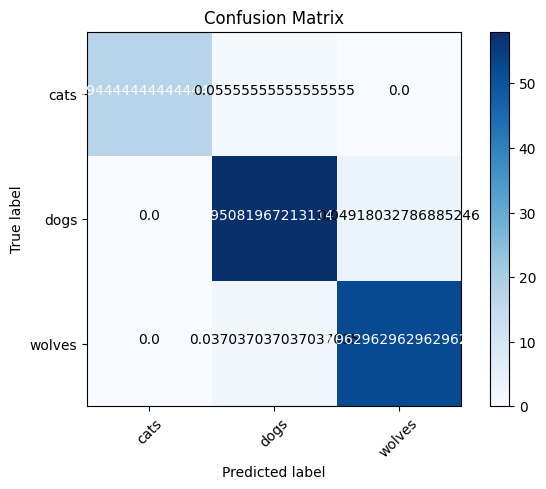

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test_batches.reset()
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     target_size=(224,224),
                                     shuffle=False,
                                     batch_size=133)
test_imgs, test_labels = next(test_batches)
# test_labels = test_labels[:,0]
predictions = model.predict(test_batches, steps=1, verbose=0)
# cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1), binary=False)
cm_plot_labels = classes
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history = model.fit(
    train_batches,
    steps_per_epoch=train_batches.samples // 15,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples // 8,
    epochs=15,
    verbose=1
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9599 - loss: 0.1136 - val_accuracy: 0.4205 - val_loss: 2.4934
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1177 - val_accuracy: 0.5000 - val_loss: 4.4861
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9756 - loss: 0.0837 - val_accuracy: 0.4886 - val_loss: 1.4153
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9333 - loss: 0.1969 - val_accuracy: 0.5000 - val_loss: 1.4805
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9860 - loss: 0.0930 - val_accuracy: 0.5455 - val_loss: 1.9465
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8667 - loss: 0.3523 - val_accuracy: 0.0000e+00 - val_loss: 2.4990
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0287 - val_accuracy: 0.4886 - val_loss: 2.4600
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.0000e

In [ ]:
test_loss, test_acc = model.evaluate(test_batches, steps=1, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Test Loss: 1.9786021709442139
Test Accuracy: 0.4436090290546417


## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining.

In [ ]:
# model.save('animalsVGG16.h5')
# print("Model Saved.")

## Loading the fine-tuned VGG16 model

In a production environment, the model could be loaded.

In [ ]:
# model.load_weights('animalsVGG16.h5')
# print("Model Loaded.")

## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is uploaded and connected to the Keras API. Then, the model is defined by copying a pretrained model and adding a new output layer. Once defined, the model can be trained using the appropriate loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict multiple classes beyond two, as well as predicting scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets.